<a href="https://colab.research.google.com/github/JSJeong-me/AI-Innovation-2024/blob/main/2-3-classification-performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 이미지 분류

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/images/classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행하기</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드하기</a></td>
</table>

이 튜토리얼은 `tf.keras.Sequential` 모델을 사용하여 꽃 이미지를 분류하고 `tf.keras.utils.image_dataset_from_directory`를 사용하여 데이터를 로드하는 방법을 보여줍니다. 다음 개념을 설명합니다.

- 디스크에서 데이터세트를 효율적으로 로드합니다.
- 데이터 증강 및 드롭아웃을 포함하여 과대적합을 식별하고 이를 완화하는 기술을 적용합니다.

이 튜토리얼은 기본적인 머신러닝 워크플로를 따릅니다.

1. 데이터 검사 및 이해하기
2. 입력 파이프라인 빌드하기
3. 모델 빌드하기
4. 모델 훈련하기
5. 모델 테스트하기
6. 모델을 개선하고 프로세스 반복하기

또한 이 노트북은 모바일, 임베디드 및 IoT 장치에서 온디바이스 머신 러닝을 위해 [저장된 모델](../../../guide/saved_model.ipynb)을 [TensorFlow Lite](https://www.tensorflow.org/lite/) 모델로 변환하는 방법을 보여줍니다.

## 설정

TensorFlow 및 기타 필요한 라이브러리를 가져옵니다.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## 데이터세트 다운로드 및 탐색하기

이 튜토리얼에서는 약 3,700장의 꽃 사진 데이터세트를 사용합니다. 데이터세트에는 클래스당 하나씩 5개의 하위 디렉터리가 있습니다.

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [3]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


다운로드 후, 데이터세트 사본을 사용할 수 있습니다. 총 3,670개의 이미지가 있습니다.

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


장미의 경우는 다음과 같습니다.

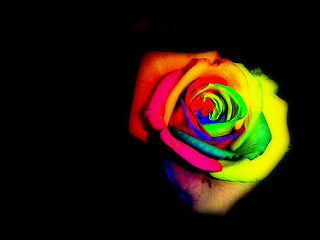

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

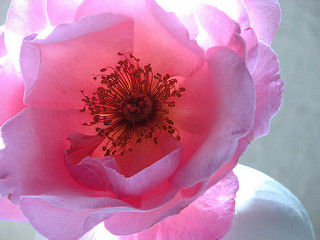

In [6]:
PIL.Image.open(str(roses[1]))

그리고 일부 튤립이 있습니다.

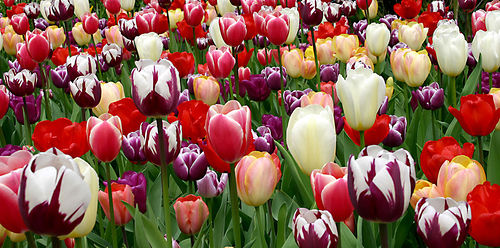

In [7]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

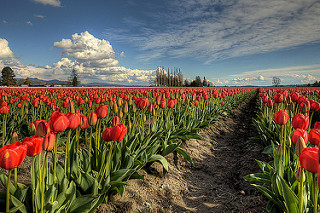

In [8]:
PIL.Image.open(str(tulips[1]))

## Keras 유틸리티를 사용하여 데이터 로드하기

다음으로, 유용한 `tf.keras.utils.image_dataset_from_directory` 유틸리티를 사용하여 디스크에서 이러한 이미지를 로드해 보겠습니다. 이러면 몇 줄의 코드로 디스크의 이미지 디렉터리에서 `tf.data.Dataset`로 이동하게 됩니다. 원하는 경우 [이미지 로드 및 전처리](../load_data/images.ipynb) 튜토리얼을 방문하여 처음부터 자체 데이터 로드 코드를 작성할 수도 있습니다.

### 데이터세트 만들기

로더에 대한 몇 가지 매개변수를 정의합니다.

In [9]:
batch_size = 32
img_height = 180
img_width = 180

모델을 개발할 때 검증 분할을 사용하는 것이 좋습니다. 이미지의 80%를 훈련에 사용하고 20%를 검증에 사용합니다.

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


이러한 데이터세트의 `class_names` 속성에서 클래스 이름을 찾을 수 있습니다. 이들 클래스 이름은 알파벳 순서의 디렉토리 이름에 해당합니다.

In [12]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## 데이터 시각화하기

다음은 훈련 데이터세트의 처음 9개 이미지입니다.

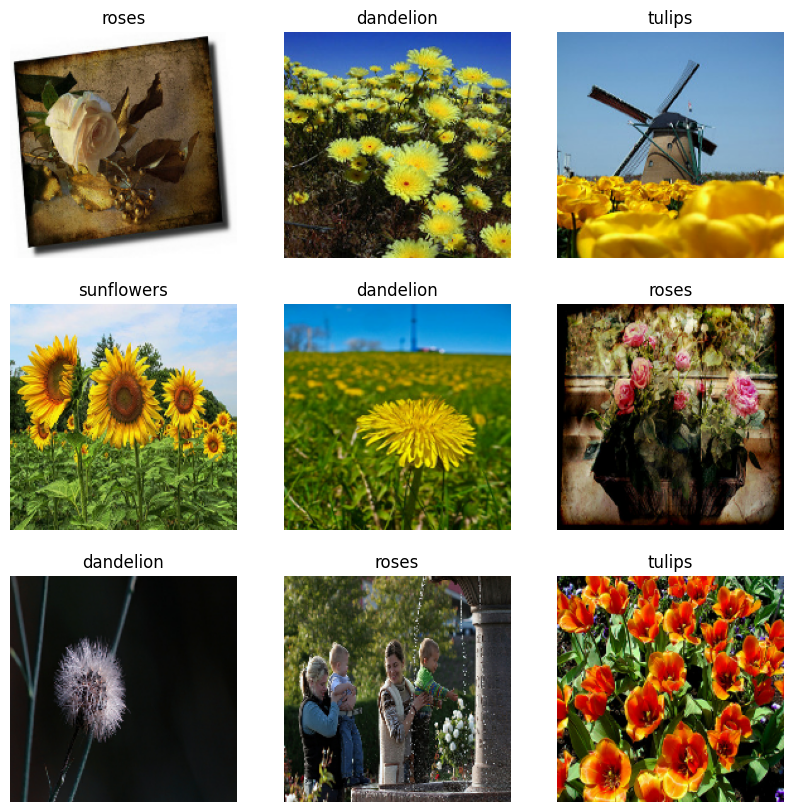

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

이 튜토리얼의 뒷부분에서 훈련을 위해 이러한 데이터세트를 `Model.fit` 메서드에 전달합니다. 원하는 경우 데이터세트를 수동으로 반복하고 이미지 배치를 가져올 수도 있습니다.

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


`image_batch`는 `(32, 180, 180, 3)` 형상의 텐서이며, `180x180x3` 형상의 32개 이미지 묶음으로 되어 있습니다(마지막 차원은 색상 채널 RGB를 나타냄). `label_batch`는 형상 `(32,)`의 텐서이며 32개 이미지에 해당하는 레이블입니다.

`image_batch` 및 `labels_batch` 텐서에서 `.numpy()`를 호출하여 이를 `numpy.ndarray`로 변환할 수 있습니다.


## 성능을 높이도록 데이터세트 구성하기

버퍼링된 프리페치를 사용하여 I/O를 차단하지 않고 디스크에서 데이터를 생성할 수 있도록 하겠습니다. 데이터를 로드할 때 다음 두 가지 중요한 메서드를 사용해야 합니다.

- `Dataset.cache()`는 첫 epoch 동안 디스크에서 이미지를 로드한 후 이미지를 메모리에 유지합니다. 이렇게 하면 모델을 훈련하는 동안 데이터세트가 병목 상태가 되지 않습니다. 데이터세트가 너무 커서 메모리에 맞지 않는 경우, 이 메서드를 사용하여 성능이 높은 온디스크 캐시를 생성할 수도 있습니다.
- `Dataset.prefetch`는 훈련하는 동안 데이터 전처리 및 모델 실행을 중첩시킵니다.

관심 있는 독자는 <a>tf.data API를 통한 성능 향상</a> 가이드의 <em>프리페치</em> 섹션에서 두 가지 메서드와 데이터를 디스크에 캐시하는 방법에 대해 자세히 알아볼 수 있습니다.

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 데이터 표준화하기

RGB 채널 값은 `[0, 255]` 범위에 있습니다. 이것은 신경망에 이상적이지 않습니다. 일반적으로 입력 값을 작게 만들어야 합니다.

여기에서 `tf.keras.layers.Rescaling`을 사용하여 값을 `[0, 1]` 범위로 표준화합니다.

In [16]:
normalization_layer = layers.Rescaling(1./255)

이 레이어를 사용하는 방법에는 두 가지가 있습니다. `Dataset.map`을 호출하여 데이터세트에 이를 적용할 수 있습니다.

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9407408


또는 모델 정의 내부에 레이어를 포함하여 배포를 단순화할 수 있습니다. 여기에서는 두 번째 접근 방식을 사용합니다.

참고: 이전에 `tf.keras.utils.image_dataset_from_directory`의 `image_size` 인수를 사용하여 이미지 크기를 조정했습니다. 해당 모델에도 크기 조정 논리를 포함하려면 `tf.keras.layers.Resizing` 레이어를 사용할 수 있습니다.

## 기본 Keras 모델

### 모델 만들기

Keras [순차형](https://www.tensorflow.org/guide/keras/sequential_model) 모델은 각각에 최대 풀링 레이어(`tf.keras.layers.MaxPooling2D`)가 있는 3개의 컨볼루션 블록(`tf.keras.layers.Conv2D`)으로 구성됩니다. ReLU 활성화 함수(`'relu'`)에 의해 활성화되는 128개 유닛이 있는 완전 연결된 레이어(`tf.keras.layers.Dense`)가 있습니다. 이 모델은 높은 정확도를 발휘하도록 조정되지 않았습니다. 이 튜토리얼의 목표는 표준 접근 방식을 보여주는 것입니다.

In [18]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### 모델 컴파일하기

이 튜토리얼에서는 `tf.keras.optimizers.Adam` 옵티마이저와 `tf.keras.losses.SparseCategoricalCrossentropy` 손실 함수를 선택합니다. 각 훈련 epoch에 대한 훈련 및 검증 정확도를 보려면 `metrics` 인수를 `Model.compile`에 전달합니다.

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### 모델 요약

Keras `Model.summary` 메서드를 사용하여 네트워크의 모든 레이어를 봅니다.

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### 모델 훈련하기

Keras `Model.fit` 메서드를 사용하여 10 epoch 동안 모델을 훈련합니다.

In [21]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 167ms/step - accuracy: 0.3002 - loss: 1.7337 - val_accuracy: 0.5054 - val_loss: 1.1698
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5419 - loss: 1.0914 - val_accuracy: 0.5926 - val_loss: 1.0359
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6784 - loss: 0.8456 - val_accuracy: 0.6403 - val_loss: 0.9584
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7683 - loss: 0.6315 - val_accuracy: 0.6376 - val_loss: 0.9544
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8456 - loss: 0.4331 - val_accuracy: 0.6403 - val_loss: 1.0423
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9127 - loss: 0.2759 - val_accuracy: 0.6540 - val_loss: 1.3089
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9576 - loss: 0.1519 - val_accuracy: 0.6294 - val_loss: 1.6166
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9485 - loss: 0.1487 - val_accuracy: 0.6471 -

## 훈련 결과 시각화하기

훈련 및 검증 세트에 대한 손실과 정확성 플롯을 생성합니다.

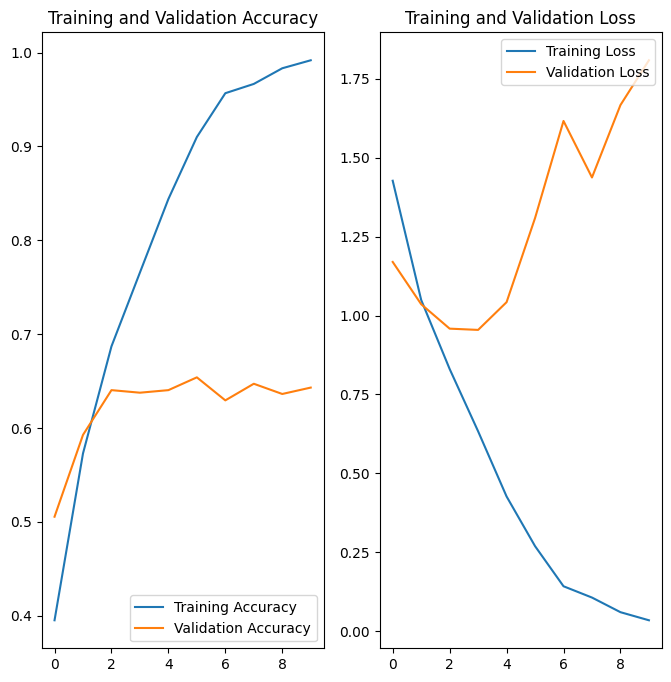

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

플롯은 훈련 정확도와 검증 정확도가 큰 차이로 떨어져 있으며 모델은 검증 세트에서 약 60%의 정확도만을 달성했음을 보여줍니다.

다음 튜토리얼 섹션에서는 무엇이 잘못되었는지 검사하고 모델의 전체 성능을 높이는 방법을 보여줍니다.

## 과대적합

위의 플롯에서 훈련 정확성은 시간이 지남에 따라 선형적으로 증가하는 반면, 검증 정확성은 훈련 과정에서 약 60%를 벗어나지 못합니다. 또한 훈련 정확성과 검증 정확성 간의 정확성 차이가 상당한데, 이는 [과대적합](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)의 징후입니다.

훈련 예제가 적을 때 모델은 새로운 예제에서 모델의 성능에 부정적인 영향을 미치는 정도까지 훈련 예제의 노이즈나 원치 않는 세부까지 학습합니다. 이 현상을 과대적합이라고 합니다. 이는 모델이 새 데이터세트에서 일반화하는 데 어려움이 있음을 의미합니다.

훈련 과정에서 과대적합을 막는 여러 가지 방법들이 있습니다. 이 튜토리얼에서는 *데이터 증강*을 사용하고 모델에 *드롭아웃*을 추가합니다.

## 데이터 증강

과대적합은 일반적으로 훈련 예제가 적을 때 발생합니다. [데이터 증강](./data_augmentation.ipynb)은 증강한 다음 믿을 수 있는 이미지를 생성하는 임의 변환을 사용하는 방법으로 기존 예제에서 추가 훈련 데이터를 생성하는 접근법을 취합니다. 그러면 모델이 데이터의 더 많은 측면을 파악하게 되므로 일반화가 더 쉬워집니다.

Keras 전처리 레이어 `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, `tf.keras.layers.RandomZoom`을 사용하여 데이터 증강을 구현합니다. 다른 레이어처럼 이를 모델 내부에 포함시키고 GPU에서 실행할 수 있습니다.

In [23]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

동일한 이미지에 데이터 증강을 여러 번 적용하여 몇 가지 증강 예제를 시각화합니다.

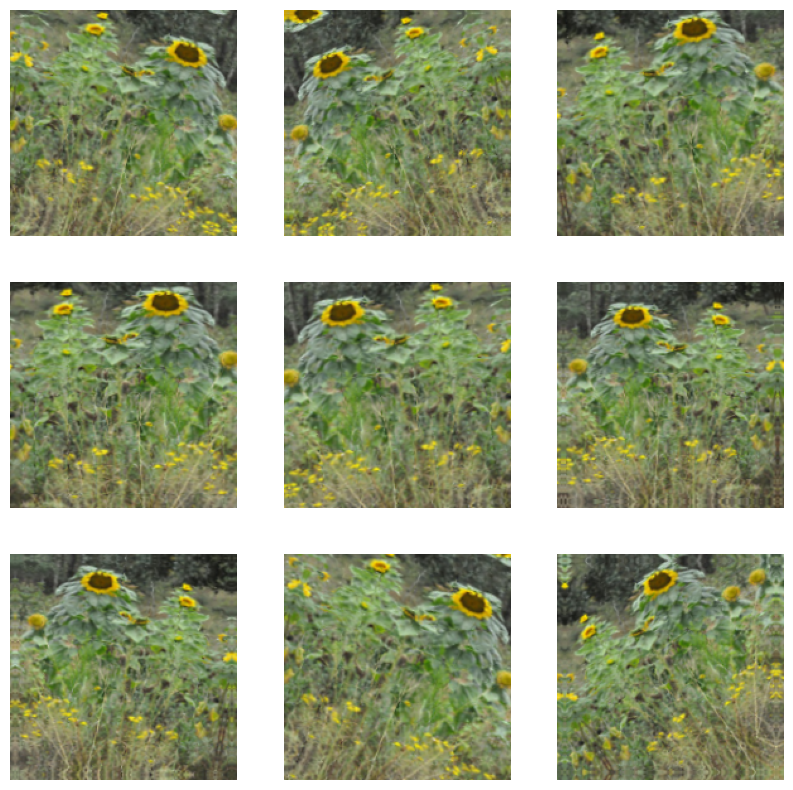

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

다음 단계에서 훈련하기 전에 모델에 데이터 증강을 추가합니다.

## 드롭아웃

과대적합을 줄이는 또 다른 기술은 네트워크에 [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization){:.external} 정규화를 도입하는 것입니다.

드롭아웃을 레이어에 적용하면, 훈련 프로세스 중에 레이어에서 여러 출력 단위가 무작위로 드롭아웃됩니다(활성화를 0으로 설정). 드롭아웃은 0.1, 0.2, 0.4 등의 형식으로 소수를 입력 값으로 사용합니다. 이는 적용된 레이어에서 출력 단위의 10%, 20% 또는 40%를 임의로 제거하는 것을 의미합니다.

증강 이미지를 사용하여 훈련하기 전에 `tf.keras.layers.Dropout`을 사용하여 새로운 신경망을 생성합니다.

In [25]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## 모델 컴파일 및 훈련하기

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ outputs (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [28]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.3220 - loss: 1.5510 - val_accuracy: 0.5518 - val_loss: 1.1273
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.5493 - loss: 1.0769 - val_accuracy: 0.5886 - val_loss: 1.0761
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.6296 - loss: 0.9518 - val_accuracy: 0.6226 - val_loss: 0.9404
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.6694 - loss: 0.8726 - val_accuracy: 0.6253 - val_loss: 0.9662
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.6766 - loss: 0.8130 - val_accuracy: 0.6594 - val_loss: 0.8870
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7116 - loss: 0.7634 - val_accuracy: 0.6717 - val_loss: 0.8510
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.7200 - loss: 0.7331 - val_accuracy: 0.6962 - val_loss: 0.7705
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7486 - loss: 0.6879 - val_accuracy: 0.7071 - v

## 훈련 결과 시각화하기

데이터 증강 및 `tf.keras.layers.Dropout` 적용 후 이전보다 과대적합이 적고 훈련 및 검증 정확도가 더 밀접하게 정렬됩니다.

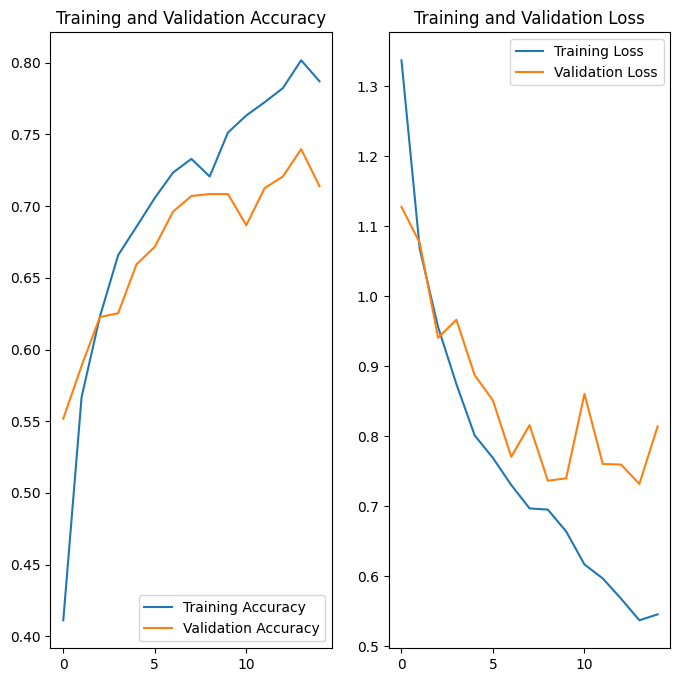

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 새로운 데이터로 예측하기

모델을 사용하여 훈련 또는 검증 세트에 포함되지 않은 이미지를 분류합니다.

참고: 데이터 증강 및 드롭아웃 레이어는 추론 시 비활성화됩니다.

In [30]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

117948/117948 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
This image most likely belongs to sunflowers with a 99.76 percent confidence.


## TensorFlow Lite 사용하기

TensorFlow Lite는 개발자가 모바일, 임베디드 및 엣지 기기에서 모델을 실행할 수 있도록 도와주어 온디바이스 머신 러닝을 지원하는 도구 세트입니다.

### Keras 순차형 모델을 TensorFlow Lite 모델로 변환하기

훈련된 모델을 온디바이스 애플리케이션에 사용하려면 먼저 [TensorFlow Lite](https://www.tensorflow.org/lite/models/convert) 모델이라는 더 작고 효율적인 모델 형식으로 [이를 변환](https://www.tensorflow.org/lite/)해야 합니다.

이 예제에서는 `tf.lite.TFLiteConverter.from_keras_model`을 사용하여 훈련된 Keras 순차형 모델로부터 [TensorFlow Lite](https://www.tensorflow.org/lite/) 모델을 생성합니다.

In [31]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmp7me8l3us'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name='keras_tensor_17')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  137851036801280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137852538037952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137852538028448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137852538029680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137852519943152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137852519948608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137852538032848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137852537977872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137852537968544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137852537978400: TensorSpec(shape=(), dtype=tf.resource, name=None)


이전 단계에서 저장한 TensorFlow Lite 모델에는 여러 함수 서명이 포함될 수 있습니다. Keras 모델 변환기 API는 기본 서명을 자동으로 사용합니다. [TensorFlow Lite 서명](https://www.tensorflow.org/lite/guide/signatures)에 대해 자세히 알아보세요.

### TensorFlow Lite 모델 실행하기

`tf.lite.Interpreter` 클래스를 통해 Python에서 TensorFlow Lite의 저장된 모델 서명에 액세스할 수 있습니다.

`Interpreter`로 모델을 로드합니다.

In [32]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

변환된 모델의 서명을 인쇄하여 입력(및 출력)의 이름을 얻습니다.


In [33]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['keras_tensor_17'], 'outputs': ['output_0']}}

이 예에는 `serving_default`라는 기본 서명이 하나 있습니다. 또한 `'inputs'`의 이름은 `'sequential_1_input'`이고 `'outputs'`의 이름은 `'outputs'`입니다. 이 튜토리얼의 앞부분에서 설명한 것처럼 `Model.summary`를 실행할 때 이러한 첫 번째 및 마지막 Keras 레이어 이름을 조회할 수 있습니다.

이제 다음과 같이 서명 이름을 전달하여 `tf.lite.Interpreter.get_signature_runner`로 샘플 이미지에 대한 추론을 수행하여 로드된 TensorFlow 모델을 테스트할 수 있습니다.

In [34]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

튜토리얼의 앞부분에서 수행한 것과 마찬가지로 TensorFlow Lite 모델을 사용하여 훈련 또는 검증 세트에 포함되지 않은 이미지를 분류할 수 있습니다.

이미 해당 이미지를 텐서화하고 `img_array`로 저장했습니다. 이제 로드된 TensorFlow Lite 모델(`predictions_lite`)의 첫 번째 인수(`'inputs'`의 이름)에 이를 전달하고 softmax 활성화를 계산한 다음, 계산된 확률이 가장 높은 클래스에 대한 예측을 인쇄합니다.

In [36]:
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
print(input_details)

[{'name': 'serving_default_keras_tensor_17:0', 'index': 0, 'shape': array([  1, 180, 180,   3], dtype=int32), 'shape_signature': array([ -1, 180, 180,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [ ]:
# predictions_lite = classify_lite(input_1=img_array)['outputs']

In [43]:
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# Get the correct input name from the model's signature
input_details = interpreter.get_input_details()
input_name = input_details[0]['name']  # Assuming there's only one input

classify_lite = interpreter.get_signature_runner('serving_default')

# Use the correct input name when calling classify_lite
# predictions_lite = classify_lite(**{input_name: img_array})['outputs']
# score_lite = tf.nn.softmax(predictions_lite)

In [ ]:
predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

In [42]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

NameError: name 'score_lite' is not defined

Lite 모델에서 생성된 예측은 원래 모델에서 생성된 예측과 거의 동일해야 합니다.

In [ ]:
print(np.max(np.abs(predictions - predictions_lite)))

5가지 클래스 `'daisy'`, `'dandelion'`, `'roses'`, `'sunflowers'` 및 `'tulips'` 중에서 모델은 이미지가 해바라기에 속하는 것으로 예측해야 하며, 이는 TensorFlow Lite 변환 이전과 동일한 결과입니다.


## 다음 단계

이 튜토리얼에서는 이미지 분류를 위해 모델을 훈련 및 테스트하고, 온디바이스 애플리케이션(예: 이미지 분류 앱)에 사용하도록 TensorFlow Lite 형식으로 변환하고, Python API를 사용하여 TensorFlow Lite 모델로 추론을 수행하는 방법을 보여주었습니다.

[튜토리얼](https://www.tensorflow.org/lite/tutorials) 및 [가이드](https://www.tensorflow.org/lite/guide)를 통해 TensorFlow Lite에 대해 자세히 알아볼 수 있습니다.